<a href="https://colab.research.google.com/github/Vishu6744/RL/blob/main/Rl_Vishu_Practical4_Baby_Robot_Part_3_UCB_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# include the power socket setup, base classes and helpers
# (see PowerSocketSystem.py)
from PowerSocketSystem import *

In [5]:
class UCBSocket( PowerSocket ):

    def __init__( self, q, **kwargs ):
        """ initialize the UCB socket """

        # store the confidence level controlling exploration
        self.confidence_level = kwargs.pop('confidence_level', 2.0)

        # pass the true reward value to the base PowerSocket
        super().__init__(q)

    def uncertainty(self, t):
        """ calculate the uncertainty in the estimate of this socket's mean """
        if self.n == 0: return float('inf')
        return self.confidence_level * (np.sqrt(np.log(t) / self.n))

    def sample(self,t):
        """ the UCB reward is the estimate of the mean reward plus its uncertainty """
        return self.Q + self.uncertainty(t)

In [6]:
class UCBSocketTester( SocketTester ):

    def __init__(self, socket_order=socket_order, confidence_level=2.0 ):
        """ initialize the socket tester """
        super().__init__(socket = UCBSocket,
                         socket_order = socket_order,
                         confidence_level = confidence_level,
                         number_of_stats = 3) # a UCB socket tester records 3 bits of information over a run

    def get_socket_stats( self, t ):
        """ record the current values of each socket """
        socket_stats = [[socket.Q,socket.n,socket.uncertainty(t+1)] for socket in self.sockets]
        return socket_stats

    def select_socket( self, t ):
        """ choose the socket with the current highest UCB reward """
        socket_index = random_argmax([socket.sample(t+1) for socket in self.sockets])
        return socket_index

In [7]:
# do a single run with only 2 sockets to examine how the exploration and exploitation terms of the UCB equation vary
number_of_sockets = 2
number_of_steps = 20

# set the random seed to produce a recreatable graph
random.seed(0)
np.random.seed(0)

tester = UCBSocketTester( socket_order[:number_of_sockets], confidence_level = 3.0 )
tester.run( number_of_steps )

(19, 114.77150488946722)

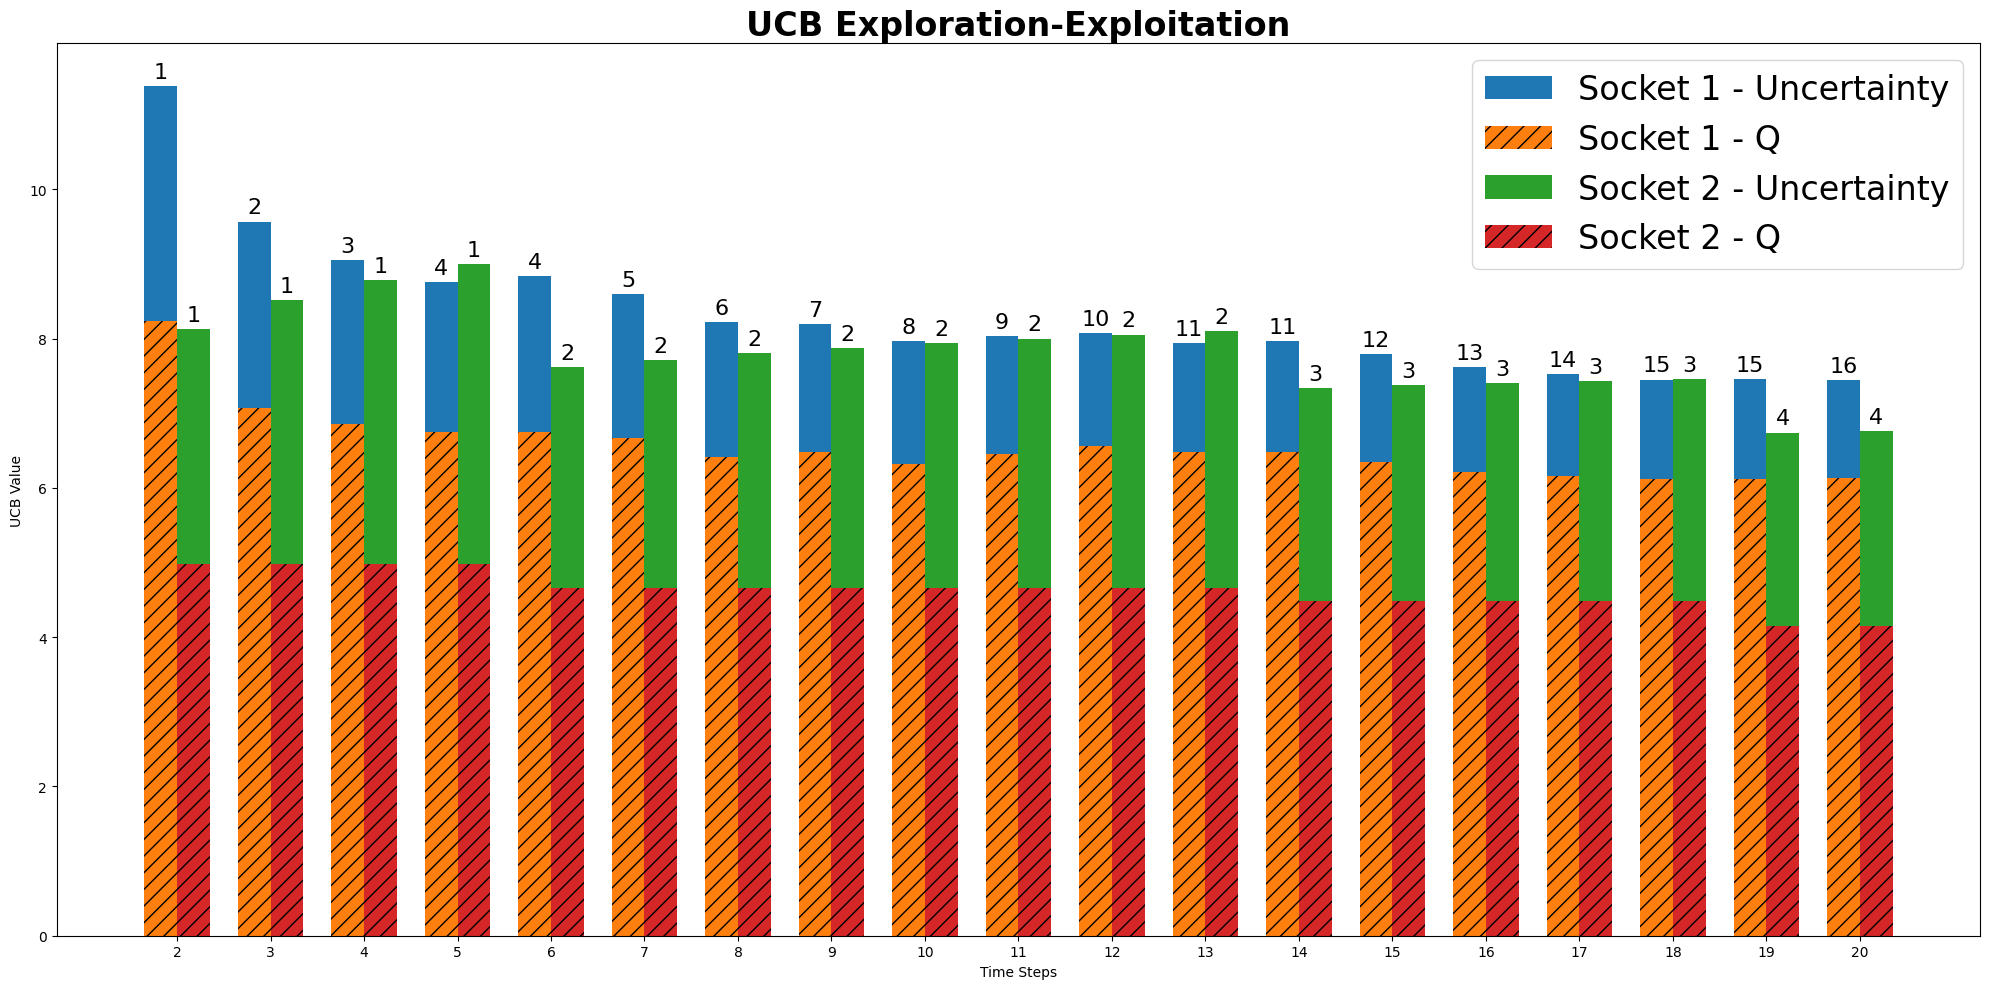

In [8]:
# get the parameters to graph from the socket stats
estimates = tester.socket_stats[:,:,0]
trials = tester.socket_stats[:,:,1]
uncertainty = tester.socket_stats[:,:,2]

# the label locations
# - start the examination after all sockets have been tried once
x = np.arange(len(estimates[:,0]))[2:]
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10))

rects1 = [ plt.bar(x, uncertainty[2:,0]+estimates[2:,0], align='edge', width= -width, label='Socket 1 - Uncertainty'),
           plt.bar(x, estimates[2:,0], align='edge', width= -width, label='Socket 1 - Q', hatch='//')]

rects2 = [ plt.bar(x, uncertainty[2:,1]+estimates[2:,1], align='edge',width= width, label='Socket 2 - Uncertainty'),
           plt.bar(x, estimates[2:,1], align='edge',width= width, label='Socket 2 - Q', hatch='//')]

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('UCB Value')
ax.set_xlabel('Time Steps')
ax.set_title('UCB Exploration-Exploitation', fontsize=24, fontweight='bold')
ax.legend(fontsize=24)
ax.set_xticks(x)


def autolabel(rects,index,trials):
    """Attach a text label above each bar in *rects*, displaying its number of trials"""

    for i,rect in enumerate(rects[0]):
        height = rect.get_height()
        ax.annotate('{:.0f}'.format(trials[i+2,index]),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    size=16,
                    ha='center', va='bottom')


autolabel(rects1,0,trials)
autolabel(rects2,1,trials)

fig.tight_layout()

# plt.savefig('ucb_exploration_exploitation.png')
plt.show()

In [9]:
def plot_ucb_socket_percentages( confidence_values, socket_percentages, number_of_steps ):

    df = pd.DataFrame(socket_percentages)
    for socket in range(df.shape[1]):
        plt.plot(confidence_values, df[socket]*100, label = f'{socket+1}', marker='o', linestyle='--')

    plt.plot(confidence_values, np.ones(df.shape[0])*20,'k')

    plt.legend(title = 'Sockets')
    plt.title('Socket Selection Percentage vs Confidence Level', fontsize=15)
    plt.xlabel('Confidence Level')
    plt.ylabel('Socket Selection (%)')


def plot_ucb_reward_per_timestep( confidence_values, reward_per_timestep, number_of_steps, figsize=(10,8) ):

    plt.plot( confidence_values, reward_per_timestep, marker='o', linestyle='--', color='r')
    plt.title('Mean Total Reward per Time Step vs Confidence Level', fontsize=15)
    plt.xlabel('Confidence Level')
    plt.ylabel('Mean Total Reward per Time Step')


def plot_ucb(confidence_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates, number_of_steps ):
    fig = plt.figure(figsize=(24,10))

    plt.suptitle(f'Upper Confidence Bound: {number_of_steps} time-steps per run', fontsize=20, fontweight='bold')

    plt.subplot(1, 2, 1)
    plot_ucb_socket_percentages( confidence_values, socket_percentages, number_of_steps )

    plt.subplot(1, 2, 2)
    plot_ucb_reward_per_timestep( confidence_values, reward_per_timestep, number_of_steps )

    plt.savefig(f"Images/ucb_{number_of_steps}.png")
    plt.show()

In [10]:
def ucb_experiment( number_of_tests, number_of_steps, confidence_level = 3.0):

    experiment = SocketExperiment(socket_tester   = UCBSocketTester( confidence_level = confidence_level ),
                                  number_of_tests = number_of_tests,
                                  number_of_steps = number_of_steps)
    experiment.run()

    return experiment.get_estimates(),\
           experiment.get_mean_total_reward(),\
           experiment.get_optimal_selected(),\
           experiment.get_socket_percentages()

In [11]:
def run_ucb_experiment( start, end, step = 0.01, number_of_tests = 100, number_of_steps = 300 ):

    test_values = []
    reward_per_timestep = []
    optimal_selected = []
    socket_percentages = []
    final_socket_estimates = []

    # iterate over the confidence level values
    for confidence_level in tqdm( np.arange( start, (end+step), step ) ):

        # save the test value used to run this test
        test_values.append( confidence_level )

        mean_estimates, mean_reward_per_timestep, mean_optimal_selected, mean_socket_percentage = ucb_experiment( number_of_tests, number_of_steps, confidence_level )

        reward_per_timestep.append( mean_reward_per_timestep )
        optimal_selected.append( mean_optimal_selected )
        socket_percentages.append( mean_socket_percentage )
        final_socket_estimates.append( mean_estimates[-1] )

    return test_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates

In [12]:
# how many times each test should be run
number_of_tests = 500

# the confidence level test range
start = 0
stop = 100.0
step = 5

number_of_steps = 100
confidence_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates = \
    run_ucb_experiment( start, stop, step, number_of_tests, number_of_steps )

100%|██████████| 21/21 [00:59<00:00,  2.82s/it]


FileNotFoundError: ignored

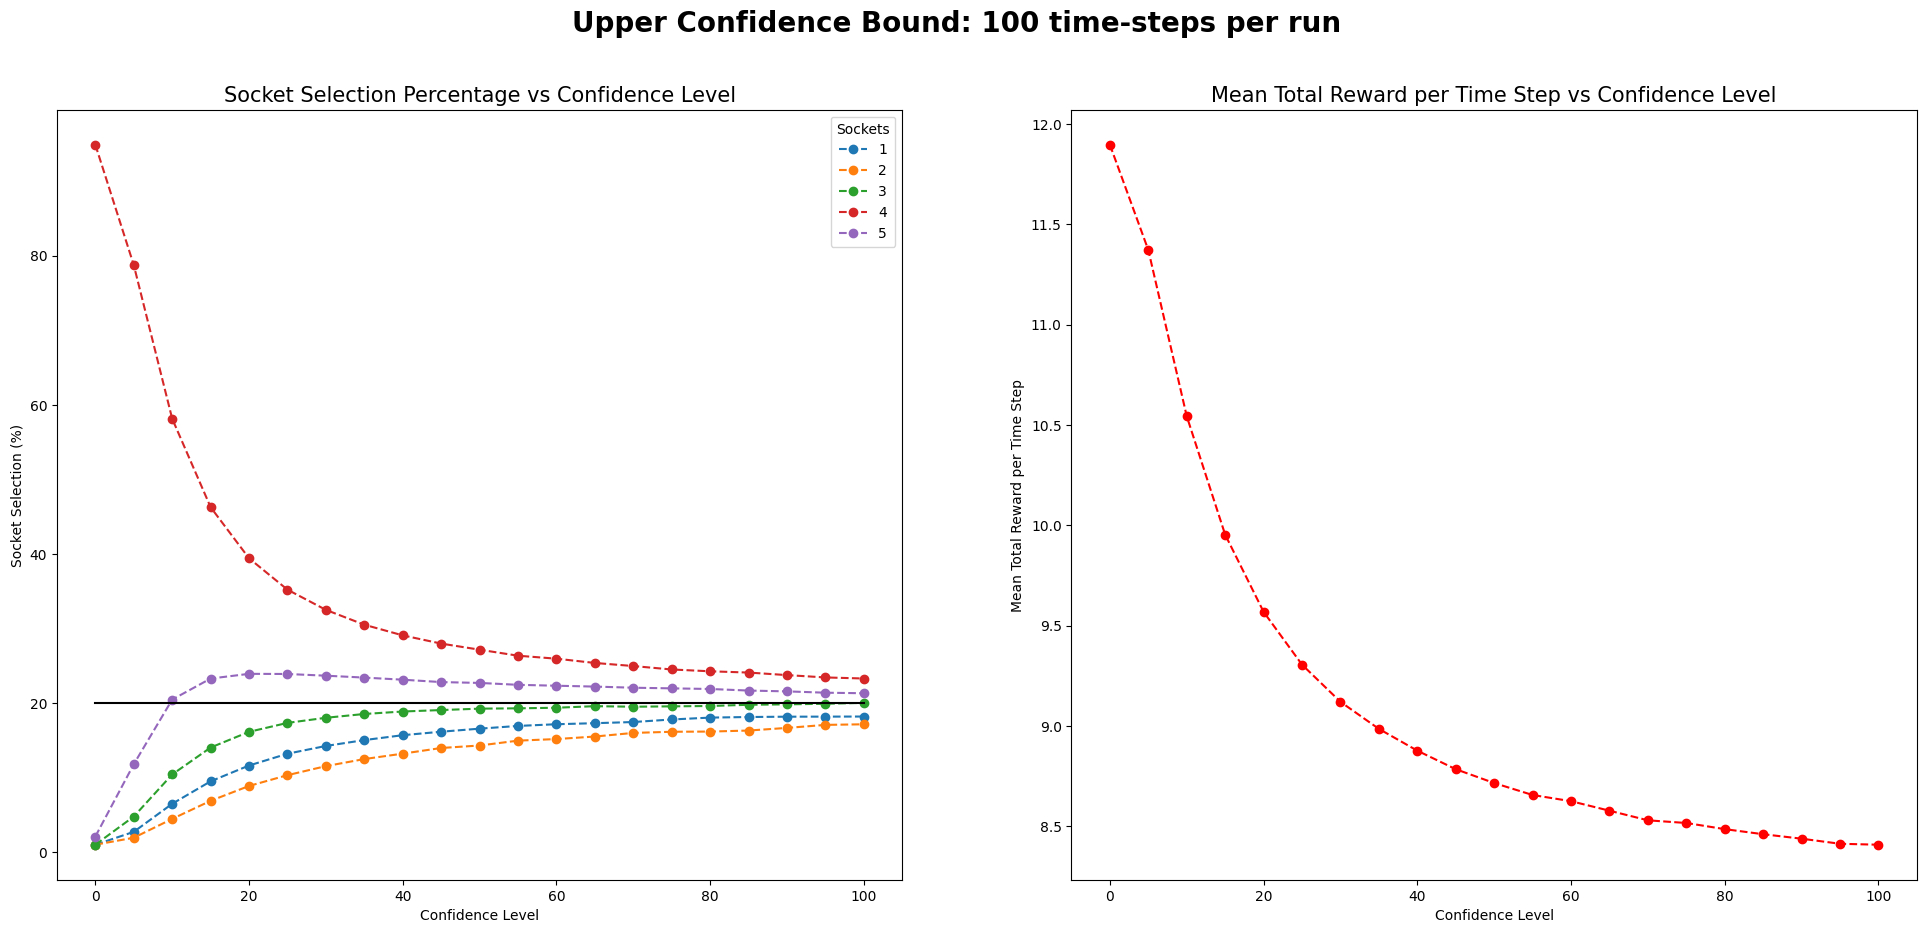

In [14]:
plot_ucb(confidence_values,
         reward_per_timestep,
         optimal_selected,
         socket_percentages,
         final_socket_estimates,
         number_of_steps )

In [ ]:
# how many times each test should be run
number_of_tests = 1000

# the confidence level test range
start = 0.
stop = 2.0
step = 0.1

number_of_steps = 50
confidence_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates = \
    run_ucb_experiment( start, stop, step, number_of_tests, number_of_steps )

FileNotFoundError: ignored

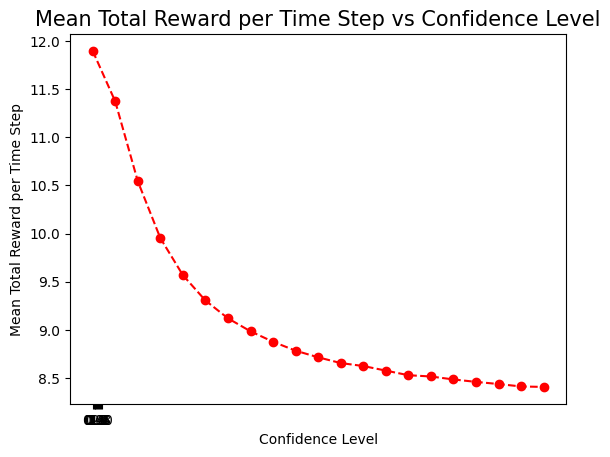

In [17]:
plt.xticks(np.arange(0., 2.2, 0.2))
plt.plot( confidence_values, reward_per_timestep, marker='o', linestyle='--', color='r')
plt.title('Mean Total Reward per Time Step vs Confidence Level', fontsize=15)
plt.xlabel('Confidence Level')
plt.ylabel('Mean Total Reward per Time Step')
plt.savefig(f"Images/ucb_reward_per_timestep{number_of_steps}.png")

In [16]:
# create and test UCB sockets
tester = UCBSocketTester( confidence_level = 0.6)
tester.run( number_of_steps = 1000 )

print(f'Mean Reward per Time Step = {tester.get_mean_reward()}')
print(f'Optimal Socket Selected = {tester.get_optimal_socket_percentage()}')
print(f'Socket Percentages = {tester.get_socket_percentages()}')

Mean Reward per Time Step = 11.967928802100644
Optimal Socket Selected = 0.995995995995996
Socket Percentages = [0.001 0.001 0.001 0.996 0.001]


In [15]:
# run the test 100 times with each test running for 1000 timesteps
number_of_tests = 1000
number_of_steps = 1000

experiment = SocketExperiment(socket_tester   = UCBSocketTester( confidence_level = 0.6 ),
                              number_of_tests = number_of_tests,
                              number_of_steps = number_of_steps)
experiment.run()

In [ ]:
number_of_trials = experiment.get_number_of_trials()

plt.figure(figsize=(10,8))
for socket in range(number_of_trials.shape[1]):
    plt.plot(number_of_trials[:30,socket], label = f'{socket+1}')

plt.title('UCB Number of Trials vs Time', fontsize=20, fontweight='bold')
plt.legend(title = 'Sockets')
plt.xlabel('Time Steps')
plt.ylabel('Number of Trials')

plt.savefig("Images/UCB_number_of_trials.png")

In [ ]:
# best socket has a true mean reward of 12
cummulative_optimal_reward = [r*12 for r in range(1,number_of_steps+1)]

# regret is the difference between the optimal reward and the actual reward
regret = cummulative_optimal_reward - experiment.get_cumulative_reward_per_timestep()


fig = plt.figure(figsize=(20,6))
plt.suptitle(f'Upper Confidence Bound (UCB) Regret', fontsize=20, fontweight='bold')

plt.subplot(1, 2, 1)
plt.plot(experiment.get_cumulative_reward_per_timestep(),label = "Actual")
plt.plot(cummulative_optimal_reward, label ="Optimal")
plt.plot(regret, label ="Regret")
plt.legend()
plt.title('Cumulative Reward vs Time', fontsize=15)
plt.xlabel('Time Steps')
plt.ylabel('Total Reward')

plt.subplot(1, 2, 2)
plt.title('Regret vs Time', fontsize=15)
plt.plot(regret)
plt.xlabel('Time Steps')
plt.ylabel('Regret')

plt.savefig(f"Images/ucb_regret.png")
plt.show()